# Distribution of different test statistics under $H_{0}$ and $H_{1}$, when deriving an upper limit on the signal parameters

Here we show the distributions of the different test statistics ($t$, $q_{u.l.}$, $\sqrt{q_{u.l.}}$, $g$) in the context of deriving upper limits on the signal parameters. To illustrate we make a simple experiment of measuring the number of events in a single bin (counting experiment).

## Competing hypotheses

### $H_{0}$: s+b
### $H_{1}$: b

## Test statistics used:

- $t = -2 \ln \left[ \frac{\mathcal{L}(\mu)}{ \mathcal{L} (\hat{\mu}) }\right]$
- $q_{u.l.} = \begin{cases} -2 \ln \left[ \frac{\mathcal{L}(\mu)}{ \mathcal{L}(\hat{\mu})} \right] & \hat{\mu} \leq \mu, \\  0 & \hat{\mu} > \mu \end{cases}$
- $\sqrt{q_{u.l.}}$, just simply taking the square root of $q_{u.l.}$
- $g = \frac{\hat{\mu} - \mu}{\sigma_{\hat{\mu}}}$


In this example we take the likelihood, $\mathcal{L}$ to be the Poission likelihood, which is a function of the data ($n$ = number of events observed) and the model parameters (here $\lambda$):

$$\mathcal{L}(\text{data}, \lambda) = \frac{\lambda^{n}}{n!} e^{-\lambda}$$


The expected number of events, $\lambda$ is the sum of background events and signal events:

$$\lambda = b + \mu s_{0},$$

where $\mu$ is the signal parameter relative to a nominal value of expected number of signal events.

$\hat{\mu}$ in this example is simply:

$$\hat{\mu} = \frac{n_{obs}-b}{s_{0}}$$

Notation:
$\hat{a}$ denotes the maximum likelihood estimator (MLE) of a parameter, which is defined by:
$$\mathcal{L}|_{\hat{a}} = \mathcal{L}_{max}$$

Importing required libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import minimize

%matplotlib inline

Utility functions

In [2]:
def likelihood_poi(mu, n, bkg, s0=1.0, neg=False):
    """Return the value of the Poisson likelihood function, given the:
       - mu: signal strength parameter,
       - n: number of events observed,
       - bkg: expected number of background events,
       - s0: nominal number of signal events
       The total expected number of events is lambda = bkg + mu*s0.
       
       The `neg` argument just multiplies the likelihood by (-1).
       This is used to for the minimize() function."""
    sig = mu * s0
    exp = bkg + sig
    likelihood = poisson.pmf(n, mu=exp)
    
    if neg:
        return -likelihood
    return likelihood

In [3]:
def calc_muhat(likelihood, n, bkg, s0=1.0, simple=True):
    """Calculated the MLE estimator for mu given the:
        - likelihood: likelihood function,
        - n: number of events observed,
        - bkg: expected number of background events,
        - s0: nominal number of signal events.
        The `simple` argument switches between actually
        maximizing the Poisson distribution, or just the simple solution,
        (n-bkg)/s0"""
    if simple:
        muhat = (n-bkg)/s0
        return muhat
    else:
        res = minimize(likelihood, x0=[0.0], args=(n, bkg, s0, True), method='Nelder-Mead')
        likelihood = -res['fun']
        muhat      =  res['x'][0]
        return muhat

In [4]:
def t(likelihood, mu, n, bkg, s0=1.0):
    """Calculates the value of the test statistic t"""
    muhat = calc_muhat(likelihood, n, bkg, s0)
    ll1   = np.log( likelihood(mu,    n, bkg, s0=s0) )
    ll2   = np.log( likelihood(muhat, n, bkg, s0=s0) )
    t = -2.0 * (ll1 - ll2)
    return t

In [5]:
def q_ul(likelihood, mu, n, bkg, s0=1.0):
    """Calculates the value of the test static q_{u.l}"""
    muhat = calc_muhat(likelihood, n, bkg, s0)
    if muhat > mu:
        return 0.0
    ll1   = np.log( likelihood(mu,    n, bkg, s0=s0) )
    ll2   = np.log( likelihood(muhat, n, bkg, s0=s0) )
    t = -2.0 * (ll1 - ll2)
    return t

In [6]:
def g(likelihood, mu, n, bkg, s0=1.0):
    """Calculates the value of the test statistic g"""
    muhat = calc_muhat(likelihood, n, bkg, s0)
    sigma_n  = np.sqrt(mu*s0 + bkg)
    sigma_mu = sigma_n/s0
    g = (muhat - mu)/sigma_mu
    return g

In [7]:
def get_significance_from_CL(CL):
    """Calculate the significance corresponding to a confidence level"""
    p = 1.0 - CL
    Z = norm.isf(p)
    return Z

In [8]:
def calc_s(b, CL=0.95, simple=False):
    """Calculates the x% CL upper limit on the number of signal events
    given the expected number of background events."""
    Z = get_significance_from_CL(CL)
    if simple:
        s = Z * np.sqrt(b)
    else:
        s = 0.5*Z*(Z + np.sqrt(1.0+4.0*b))
    return s

In [9]:
t_vec    = np.vectorize(t)
q_ul_vec = np.vectorize(q_ul)
g_vec    = np.vectorize(g)

Demonstrating that `muhat()`, `t()` and `q_ul` it works correctly:

In [35]:
calc_muhat(likelihood_poi, n=15.0, bkg=10.0)

5.0

In [36]:
calc_muhat(likelihood_poi,  n=15.0, bkg=10.0)

5.0

In [37]:
t(likelihood_poi, mu=0.0, n=15.0, bkg=10.0)

2.1639532432449187

In [38]:
q_ul(likelihood_poi, mu=0.0, n=5.0, bkg=10.0)

3.0685281944005425

In [39]:
q_ul(likelihood_poi, mu=0.0, n=1010.0, bkg=1000.0)

0.0

Generate a datasample

In [15]:
nSamples = 100000

In [16]:
Z = 1.64
s0 = 1.0

## Hypotheses

### Null hypothesis $H_{0}: s + b$

$H_{0}$ hypothesis parameters

In [17]:
H0_b = 1000.0
H0_s = calc_s(b=H0_b)
H0_n_pred = H0_b + H0_s
H0_mup = H0_s/s0

Above we set the number of signal events $s|_{H_{0}}$ (=`H0_s`) to be exactly the number of events that we could exclude at 95% CL for the given background $b|_{H_{0}}$ (`H0_b`). The expected limit is:

In [18]:
calc_s(b=H0_b)

53.374111963136748

Generate events

In [19]:
H0_events = poisson.rvs(mu=H0_n_pred, loc=0.0, size=nSamples)

### Alternative hypothesis $H_{1}: b$ only

$H_{1}$ hypothesis parameters

In [20]:
H1_b = 1000.0
H1_s = 0.0
H1_n_pred = H1_b + H1_s
H1_mup = H1_s/s0

Generate events

In [21]:
H1_events = poisson.rvs(mu=H1_n_pred, loc=0.0, size=nSamples)

## Distributions for the number of events observed assuming $H_{0}$ and $H_{1}$

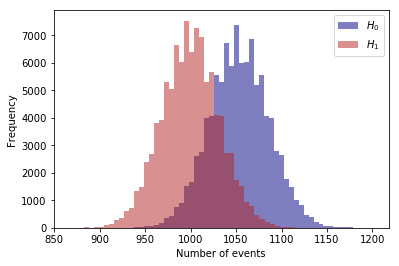

In [22]:
f, a = plt.subplots();
h0 = a.hist(H0_events, bins=50, color="navy",  label=r'$H_{0}$', alpha=0.5);
h1 = a.hist(H1_events, bins=50, color="firebrick", label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('Number of events');
a.set_ylabel('Frequency');

## Distribution of test statistic, $t$

$$t = -2 \ln \left[ \frac{\mathcal{L}(\mu)}{ \mathcal{L} (\hat{\mu}) }\right]$$

In [23]:
# - Note:
# - Depending on the the number of samples requested this might take a while.
H0_t = t_vec(likelihood_poi, mu=H0_mup,  n=H0_events, bkg=H0_b, s0=1.0)
H1_t = t_vec(likelihood_poi, mu=H0_mup,  n=H1_events, bkg=H1_b, s0=1.0)

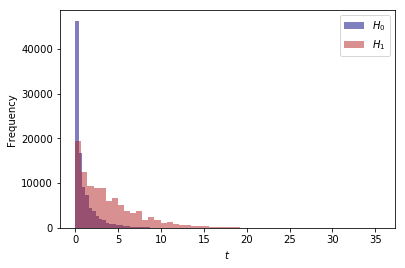

In [24]:
f, a = plt.subplots();
a.hist(H0_t, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(H1_t, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$t$');
a.set_ylabel('Frequency');

We check below if our assumption is correct (`H0_s` is indeed the number that we could exclude at 95% CL). We can do this comparing the median of $t|_{H_{1}}$ and the 95% percentile of $t|_{H_{0}}$:

In [42]:
np.median(H1_t)

2.7513197854696045

In [43]:
np.percentile(H0_t, 95)

3.7685360221785231

We see that $\text{med}(t|_{H_{1}}) \neq \text{Percentile}(t|_{H_{0}}, 95)$.

Reason: the general LLR test statistic, $t$ maps events where $\hat{\mu} > \mu$ (i.e. $\hat{s} > s$ or $n > b+s$) to non-zero values of $t$, however when setting upper limits one would not regard data with $\hat{\mu} > \mu$ as representing less compatibility with $\mu$ than the data obtained, and therefore this is not taken as part of the rejection region of the test.

## Distribution of test statistic, $q_{u.l.}$

$$q_{u.l.} = \begin{cases} -2 \ln \left[ \frac{\mathcal{L}(\mu)}{ \mathcal{L}(\hat{\mu})} \right] & \hat{\mu} \leq \mu, \\  0 & \hat{\mu} > \mu \end{cases}$$

In [25]:
# - Note:
# - Depending on the the number of samples requested this might take a while.
H0_q_ul = q_ul_vec(likelihood_poi, mu=H0_mup,  n=H0_events, bkg=H0_b, s0=1.0)
H1_q_ul = q_ul_vec(likelihood_poi, mu=H0_mup,  n=H1_events, bkg=H1_b, s0=1.0)

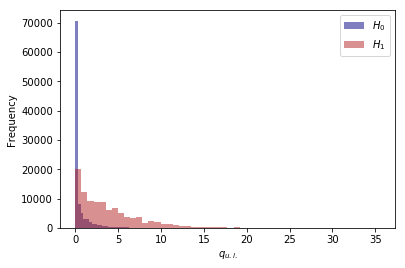

In [28]:
f, a = plt.subplots();
a.hist(H0_q_ul, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(H1_q_ul, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$q_{u.l.}$');
a.set_ylabel('Frequency');

We check again below if our assumption is correct (`H0_s` is indeed the number that we could exclude at 95% CL) now using $q_{u.l.}$. We can do this comparing the median of $q_{u.l.}|_{H_{1}}$ and the 95% percentile of $q_{u.l.}|_{H_{0}}$:

In [27]:
np.percentile(H0_q_ul, 95)

2.7513197854696045

In [26]:
np.median(H1_q_ul)

2.7513197854696045

We see that $\text{med}(q_{u.l.}|_{H_{1}}) = \text{Percentile}(q_{u.l.}|_{H_{0}}, 95)$ $\implies$ our assumption was correct.

## Distribution of test statistic, $\sqrt{q_{u.l}}$

$$\sqrt{q_{u.l.}}$$  (just simply taking the square root of $q_{u.l.}$)

In [29]:
H0_sqrt_q_ul = np.sqrt(H0_q_ul)
H1_sqrt_q_ul = np.sqrt(H1_q_ul)

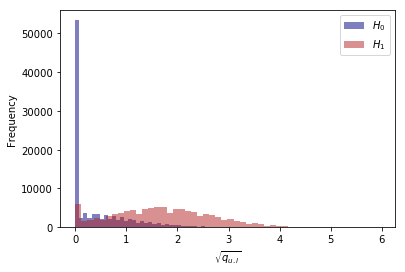

In [46]:
f, a = plt.subplots();
a.hist(H0_sqrt_q_ul, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(H1_sqrt_q_ul, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$\sqrt{q_{u.l}}$');
a.set_ylabel('Frequency');
#a.set_ylim(0.0, 1000.0)

We check again below if our assumption is correct (`H0_s` is indeed the number that we could exclude at 95% CL) now using $\sqrt{q_{u.l.}}$. We can do this comparing the median of $\sqrt{q_{u.l.}}|_{H_{1}}$ and the 95% percentile of $\sqrt{q_{u.l.}}|_{H_{0}}$:

In [44]:
np.percentile(H0_sqrt_q_ul, 95)

1.6587102777367735

In [45]:
np.median(H1_sqrt_q_ul)

1.6587102777367735

We see that $\text{med}(\sqrt{q_{u.l.}}|_{H_{1}}) = \text{Percentile}(\sqrt{q_{u.l.}}|_{H_{0}}, 95)$ $\implies$ our assumption was correct.

## Distribution of test statistic, $g$

$$g = \frac{\hat{\mu} - \mu}{\sigma_{\hat{\mu}}}$$

In [31]:
# - Note:
# - Depending on the the number of samples requested this might take a while.
H0_g = g_vec(likelihood_poi, mu=H0_mup,  n=H0_events, bkg=H0_b, s0=1.0)
H1_g = g_vec(likelihood_poi, mu=H0_mup,  n=H1_events, bkg=H1_b, s0=1.0)

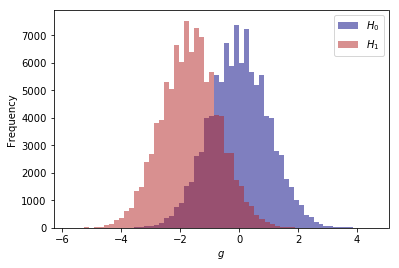

In [32]:
f, a = plt.subplots();
a.hist(H0_g, bins=50, color='navy',      label=r'$H_{0}$', alpha=0.5);
a.hist(H1_g, bins=50, color='firebrick', label=r'$H_{1}$', alpha=0.5);
handles, labels = a.get_legend_handles_labels()
a.legend(handles, labels)
a.set_xlabel('$g$');
a.set_ylabel('Frequency');
#a.set_ylim(0.0, 1000.0)

We check again below if our assumption is correct (`H0_s` is indeed the number that we could exclude at 95% CL) now using $g$. We can do this comparing the median of $g|_{H_{1}}$ and the 95% percentile (here 5% percentile, as the distribution is flipped) of $g|_{H_{0}}$:

In [34]:
np.percentile(H0_g, 5)

-1.6445206904795109

In [33]:
np.median(H1_g)

-1.6445206904795109

We see that $\text{med}(g|_{H_{1}}) = \text{Percentile}(g|_{H_{0}}, 95)$ $\implies$ our assumption was correct.